# Annexe

Ce document est un exemple de l'un des notebooks contenant le processus ainsi que la méthodologie employés dans ce projet.

## Données

Nous avons travaillés sur les données du projet Kaggle *European Soccer Database* accessible à l'adresse https://www.kaggle.com/hugomathien/soccer.

## Partie 1 - Description du problème

Reussir a predire qu'un match se termine par une victoire ou une defaite d'une equipe ou un nul des deux grace a une foret de Perceptron, seras ici notre but.<br> Dans de ce notebook, nous allons creer un classifieur qui nous permettra de predire les resultats de matchs avec un certains taux de succes, et ceux en nous basant sur les données collectés sur des equipes de 11 leagues europeenes et sur plusieurs saisons.<br>Ainsi on peut comparer nos résultats entre ce notebook, le notebook utilisant un bagging de kernel perceptron.

## Partie 2 - Modéle

* Imports

In [1]:
import random
import numpy as np
import pandas as pd
import math
import graphviz
import datetime
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

* Creation du LabeledSet

In [2]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return (self.x[i])
        
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        return (self.y[i])

* Modèle

In [3]:
class Classifier:
    def __init__(self,input_dimension):
        """ Constructeur """
        raise NotImplementedError("Please Implement this method")
    
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        raise NotImplementedError("Please Implement this method")

    
    # Permet d'entrainer le modele sur un ensemble de données étiquetés
    def train(self,labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    # Permet de calculer le taux de bonne classification
    def accuracy(self,set):
        nb_ok=0
        for i in range(set.size()):
            score = self.predict(set.getX(i))
            if (score*set.getY(i)>0):
                nb_ok = nb_ok+1
        acc = nb_ok/(set.size() * 1.0)
        return acc

In [4]:
class Perceptron(Classifier):
    
    def __init__(self, input_dimension, learning_rate, nombre_iterations, debut_saison):
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.nombre_iterations = nombre_iterations
        self.w = np.array([ 1.0,  1.0])
        self.debut_saison = debut_saison
        self.seuil = random.uniform(0,1)
    
    def predict(self, x): 
        noteD=x[0]
        noteE=x[1]
        if (abs(noteD-noteE)<self.seuil/2.0):
            return 0
        z = np.dot((noteD,noteE), self.w)
        if z > 0:
            return +1 
        else:
            return -1
        
    def train(self, labeledSet):
        datas = labeledSet
        t = labeledSet.size()
        app = LabeledSet(self.input_dimension)
        test = LabeledSet(self.input_dimension)
        for i in range(t):
            if i < t*0.8:
                app.addExample(datas.getX(i), datas.getY(i))
            else :
                test.addExample(datas.getX(i), datas.getY(i))
        for j in range (self.nombre_iterations): 
            for i in range(t):
                noteD=datas.getX(i)[0]
                noteE=datas.getX(i)[1]
                if (self.predict(datas.getX(i)) != datas.getY(i)):
                    if (self.predict(datas.getX(i)) == 0):
                        self.seuil -= 0.1
                    elif (datas.getY(i) == 0):
                        self.seuil += 0.1
                    else:
                        self.w[0] = self.w[0] + self.learning_rate * noteD * datas.getY(i)
                        self.w[1] = self.w[1] + self.learning_rate * noteE * datas.getY(i)

    def accuracy(self, dataSet):
        juste = 0
        for i in range(dataSet.size()):
            print(str(self.predict(dataSet.getX(i)))+" trouvé et attendu "+str(dataSet.getY(i)))
            if self.predict(dataSet.getX(i)) == dataSet.getY(i):
                juste += 1
        return float(juste)/float(dataSet.size())

In [8]:
class ClassifierBaggingPerceptron(Classifier):
    def __init__(self, nbPerc, pourcentage, input_dimension, learning_rate, nombre_iterations, boole,debut_saison):
        self.nbPerc=nbPerc
        self.pourcentage =pourcentage
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.nombre_iterations = nombre_iterations
        self.boole = boole
        self.debut_saison=debut_saison        
        self.ensPerc=[]
        #self.proba_domicile = proba_domicile
    
    def train(self,set):
        #x est l'id d'une equipe interieure, y exterieure
        for i in range(self.nbPerc):
            percep = Perceptron(self.input_dimension, self.learning_rate, self.nombre_iterations, self.debut_saison)
            m=int(set.size()*self.pourcentage)
            echantillon=echantillonLS(set,m,self.boole)
            percep.train(echantillon)
            self.ensPerc.append(percep)
    
    
    def predict(self,x):
        moins,plus,zero=0,0,0
        l=[0,0,0] # une liste qui represente les labels predits l[0]=>-1; l[1]=>0; l[2]=>+1
        for i in self.ensPerc:
            res=i.predict(x)
            
            if (res == 0):
                l[1] += 1
                return 0
            elif (res==1):
                l[2] += 1
                return 1
            else:
                l[0] += 1
                return -1
        return (l[np.argmax(l)]-1)
    
    def accuracy(self,set):
        nb_ok=0
        for i in range(set.size()):
            print(str(self.predict(set.getX(i)))+" trouvé et attendu "+str(set.getY(i)))
            score = self.predict(set.getX(i))
            if (score==set.getY(i)):
                nb_ok = nb_ok+1
        acc = nb_ok/(set.size() * 1.0)
        return acc

## Partie 3 - Code

* Lecture des tables

In [9]:
country = pd.read_csv("soccer/country.csv")
league = pd.read_csv("soccer/league.csv")
player = pd.read_csv("soccer/player.csv")
team = pd.read_csv("soccer/team.csv")
playerattributes = pd.read_csv("soccer/playerattributes.csv")
teamattributes = pd.read_csv("soccer/teamattributes.csv")
match = pd.read_csv("soccer/match.csv")

* Fonctions utiles

In [10]:
def isNaN(x):
    return str((x)).lower() == 'nan'

In [11]:
def tirage(X, m, r) :
    if r :
        return[X[random.choice(X)] for i in range(0, m)]
    else :
        return random.sample(X, m)

In [12]:
def echantillonLS(LSet,m,r):
    v=[i for i in range(LSet.size())]
    v=tirage(v,m,r)
    dim=LSet.getInputDimension()
    X=LabeledSet(dim)
    for j in v:
        X.addExample(LSet.getX(j),LSet.getY(j))
    
    return X

In [13]:
def matchsaison(saison,numleague):
    bdtot= LabeledSet(2)
    for i in range(len(match)):
        if(match.iloc[i]["league_id"]==numleague and saison==str(match.iloc[i]["season"])):
            res=match.iloc[i]["home_team_goal"]-match.iloc[i]["away_team_goal"]
            lab=0
            if (res>0):
                lab=+1
            elif(res<0):
                lab=-1
            else:
                lab=0
            bdtot.addExample((match.iloc[i]['home_team_api_id'],match.iloc[i]['away_team_api_id']),lab)
    return bdtot        

In [14]:
def MatchesSaisonLeague(championnat,saison):
    
   
    #avoir les matches joué a domicile pendant la saison en question
    gb=match.groupby("league_id")
    matchesSaisonLeague=gb.get_group(championnat)
    matchesSaisonLeague=matchesSaisonLeague[matchesSaisonLeague.season == saison]
    matchesSaisonLeague=matchesSaisonLeague[["home_team_api_id","away_team_api_id","date",'home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]]
    
    return matchesSaisonLeague

In [15]:
def StatJoueurSaison(saison):
    
    playerattributes['date']  = pd.to_datetime(playerattributes['date'])
    df_filtre = playerattributes[(playerattributes.date > datetime.date(int(saison[0:4]),9,1)) & (playerattributes.date < datetime.date(int(saison[5:]),8,30))]
    df_filtre=df_filtre[['player_api_id','overall_rating']]
    
    return df_filtre

In [16]:
def StatEquipesLeagueSaison(saison,championnat):
    matchesSaisonLeague=MatchesSaisonLeague(championnat,saison)
    statJoueur=StatJoueurSaison(saison)
    statEquipes=pd.DataFrame(({'team_api_id': [], 'overall_rating': []}))
    ColonnesJoueurs_home = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
                           "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
                           "home_player_11"]


    #Pour recuperer les joueurs qui font partie des 11 titulaires des matches a l'exterieur
    ColonnesJoueurs_away=["away_player_1", "away_player_2", "away_player_3", "away_player_4","away_player_5",
                          "away_player_6", "away_player_7","away_player_8", "away_player_9","away_player_10",
                          "away_player_11"]


    #avoir les matches joué a domicile pendant la saison en question
    
   


    #avoir les matches joué a l'exterieur pendant la saison en question
    
    
    ligne=0
    
    for matche in matchesSaisonLeague.itertuples():
        if matche.home_team_api_id in list(statEquipes.team_api_id):
            continue
        else:
            
            gb=matchesSaisonLeague.groupby("home_team_api_id")
            myteam_home=gb.get_group(matche.home_team_api_id)
            
           
            gb2=matchesSaisonLeague.groupby("away_team_api_id")
            myteam_away=gb.get_group(matche.home_team_api_id)
            NotesJoueursD=pd.DataFrame()
            for postejoueur in ColonnesJoueurs_home:
                # avoir la liste des joueurs ayant joué dans ce poste

                effectifs=myteam_home[postejoueur].dropna() # on utilise dropna pour eliminer tous les nan
                NotesJoueursD[postejoueur]=[0]
                noteglob=pd.DataFrame()
                note=list()
                for i in range(len(effectifs)):
                    noteglob=pd.DataFrame()

                    df_filtre=statJoueur[['player_api_id','overall_rating']]
                    note.append(df_filtre[df_filtre['player_api_id']==effectifs.iloc[i]]['overall_rating'].mean())              

                noteglob = pd.DataFrame(np.array(note), columns = ["a"]).dropna()

                NotesJoueursD[postejoueur]=[noteglob.mean()[0]]
            #print(NotesJoueursD)

            NotesJoueursA=pd.DataFrame()
            for postejoueur in ColonnesJoueurs_away:
                # avoir la liste des joueurs ayant joué dans ce poste

                effectifs=myteam_away[postejoueur].dropna() # on utilise dropna pour eliminer tous les nan

                NotesJoueursA[postejoueur]=[0]
                noteglob=pd.DataFrame()
                note=list()
                for i in range(len(effectifs)):
                    noteglob=pd.DataFrame()

                    note.append(df_filtre[df_filtre['player_api_id']==effectifs.iloc[i]]['overall_rating'].mean())              
                noteglob = pd.DataFrame(np.array(note), columns = ["a"]).dropna()

                NotesJoueursA[postejoueur]=[noteglob.mean()[0]]
        statEquipes.loc[ligne]=[matche.home_team_api_id, ((NotesJoueursA.mean(axis = 1)+NotesJoueursD.mean(axis = 1))/2)[0]]
        ligne+=1
    
    
    statEquipes.rename(columns={'overall_rating': 'team_api_id', 'team_api_id': 'overall_rating'}, inplace=True)
   
    return statEquipes.groupby('team_api_id', as_index=False).max()

In [17]:
def noteEquipe(idequipe,saison):
    #Pour recuperer les joueurs qui font partie des 11 titulaires des matches a domicile
    ColonnesJoueurs_home = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
           "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10","home_player_11"]


    #Pour recuperer les joueurs qui font partie des 11 titulaires des matches a l'exterieur
    ColonnesJoueurs_away=["away_player_1", "away_player_2", "away_player_3", "away_player_4","away_player_5", "away_player_6", "away_player_7",
                          "away_player_8", "away_player_9","away_player_10", "away_player_11"]


    #avoir les matches joué a domicile pendant la saison en question
    gb=match.groupby("home_team_api_id")
    myteam_home=gb.get_group(idequipe)
    myteam_home=myteam_home[myteam_home.season == saison]


    #avoir les matches joué a l'exterieur pendant la saison en question
    gb2=match.groupby("away_team_api_id")
    myteam_away=gb.get_group(idequipe)
    myteam_away[myteam_away.season == saison]
    playerattributes['date']  = pd.to_datetime(playerattributes['date'])
    df_filtre = playerattributes[(playerattributes.date > datetime.date(int(saison[0:4]),9,1)) & (playerattributes.date < datetime.date(int(saison[5:]),8,30))]
    df_filtre=df_filtre[['player_api_id','overall_rating']]

    
    
    NotesJoueursD=pd.DataFrame()
    for postejoueur in ColonnesJoueurs_home:
        # avoir la liste des joueurs ayant joué dans ce poste

        effectifs=myteam_home[postejoueur].dropna() # on utilise dropna pour eliminer tous les nan
        NotesJoueursD[postejoueur]=[0]
        noteglob=pd.DataFrame()
        note=list()
        for i in range(len(effectifs)):
            noteglob=pd.DataFrame()

            df_filtre=df_filtre[['player_api_id','overall_rating']]
            note.append(df_filtre[df_filtre['player_api_id']==effectifs.iloc[i]]['overall_rating'].mean()) 

        noteglob = pd.DataFrame(np.array(note), columns = ["a"]).dropna()

        NotesJoueursD[postejoueur]=[noteglob.mean()[0]]

    NotesJoueursA=pd.DataFrame()
    for postejoueur in ColonnesJoueurs_away:
        # avoir la liste des joueurs ayant joué dans ce poste

        effectifs=myteam_away[postejoueur].dropna() # on utilise dropna pour eliminer tous les nan

        NotesJoueursA[postejoueur]=[0]
        noteglob=pd.DataFrame()
        note=list()
        for i in range(len(effectifs)):
            noteglob=pd.DataFrame()

            note.append(df_filtre[df_filtre['player_api_id']==effectifs.iloc[i]]['overall_rating'].mean())  
        noteglob = pd.DataFrame(np.array(note), columns = ["a"]).dropna()

        NotesJoueursA[postejoueur]=[noteglob.mean()[0]]
    return ((NotesJoueursA.mean(axis = 1)+NotesJoueursD.mean(axis = 1))/2)[0]


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot2DSet(set):
    """ LabeledSet -> NoneType
        Hypothèse: set est de dimension 2
        affiche une représentation graphique du LabeledSet
        remarque: l'ordre des labels dans set peut être quelconque
    """
    S_pos = set.x[np.where(set.y == 1),:][0]      # tous les exemples de label +1
    S_neg = set.x[np.where(set.y == -1),:][0]     # tous les exemples de label -1
    S_nul = set.x[np.where(set.y == 0),:][0]     # tous les exemples de label 0
    plt.scatter(S_pos[:,0],S_pos[:,1],marker='o')
    plt.scatter(S_neg[:,0],S_neg[:,1],marker='x')
    plt.scatter(S_nul[:,0],S_nul[:,1],marker='v')


* Variables globales

In [19]:
annee_act = 2011
saison_av = "2010/2011"
saison_ap = "2011/2012"
numLeague=21518

In [20]:
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


* Préparation des données

In [21]:
lab=matchsaison(saison_av,numLeague)
labT=matchsaison(saison_ap,numLeague)
print(lab.size())
print(labT.size())

380
380


In [22]:
input_dimension = 2
nbPerc = 5
pourcentage = 0.5
input_dimension = 2
learning_rate = 0.1
nb_ite = 75
boole = True  

In [24]:
stats_equipes_league_saison=StatEquipesLeagueSaison(saison_av,numLeague)

## Partie 4 - Protocole expérimental

In [25]:
app = LabeledSet(input_dimension)
test = LabeledSet(input_dimension)
for i in range(lab.size()):  
    
    if(len(stats_equipes_league_saison[stats_equipes_league_saison["team_api_id"]==lab.getX(i)[0]]["overall_rating"])>0):
        NoteD=float(stats_equipes_league_saison[stats_equipes_league_saison["team_api_id"]==lab.getX(i)[0]]["overall_rating"])
    else:
        NoteD=noteEquipe(lab.getX(i)[0],saison_ap)
    
    if(len(stats_equipes_league_saison[stats_equipes_league_saison["team_api_id"]==lab.getX(i)[1]]["overall_rating"])>0):
        NoteE=float(stats_equipes_league_saison[stats_equipes_league_saison["team_api_id"]==lab.getX(i)[1]]["overall_rating"])
    else:        
        NoteE=noteEquipe(lab.getX(i)[1],saison_ap)    
    
    
    if(len(stats_equipes_league_saison[stats_equipes_league_saison["team_api_id"]==labT.getX(i)[0]]["overall_rating"])>0):
        NoteDT=float(stats_equipes_league_saison[stats_equipes_league_saison["team_api_id"]==labT.getX(i)[0]]["overall_rating"])
    else:
        NoteDT=noteEquipe(labT.getX(i)[0],saison_ap)
    
    if(len(stats_equipes_league_saison[stats_equipes_league_saison["team_api_id"]==labT.getX(i)[1]]["overall_rating"])>0):
        NoteET=float(stats_equipes_league_saison[stats_equipes_league_saison["team_api_id"]==labT.getX(i)[1]]["overall_rating"])
    
    else:        
        NoteET=noteEquipe(labT.getX(i)[1],saison_ap)  
    
    
    #print(NoteD,NoteE)
    #print(NoteDT,NoteET)
    app.addExample([NoteD,NoteE],lab.getY(i))
    test.addExample([NoteDT,NoteET],labT.getY(i))

    

In [83]:
percep = ClassifierBaggingPerceptron(nbPerc, pourcentage, input_dimension, learning_rate, nb_ite, boole,annee_act)
percep.train(app)

## Partie 5 - Résultats

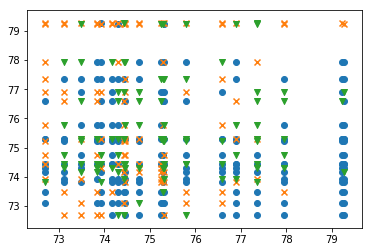

In [85]:
plot2DSet(test)

In [86]:
print("accuracy apprentissage foret perceptron:", percep.accuracy(app))

1 trouvé et attendu [1]
1 trouvé et attendu [-1]
-1 trouvé et attendu [-1]
1 trouvé et attendu [-1]
1 trouvé et attendu [0]
1 trouvé et attendu [-1]
0 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [0]
-1 trouvé et attendu [0]
1 trouvé et attendu [1]
0 trouvé et attendu [1]
-1 trouvé et attendu [-1]
1 trouvé et attendu [1]
0 trouvé et attendu [0]
1 trouvé et attendu [1]
0 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [-1]
1 trouvé et attendu [-1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
-1 trouvé et attendu [-1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [0]
0 trouvé et attendu [1]
0 trouvé et attendu [0]
1 trouvé et attendu [-1]
1 trouvé et attendu [0]
1 trouvé et attendu [0]
-1 trouvé et attendu [-1]
1 trouvé et attendu [1]
0 trouvé et attendu [1]
1 trouvé et attendu [-1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [-1]

In [97]:
print("accuracy teste foret perceptron:", percep.accuracy(test)) 

1 trouvé et attendu [-1]
1 trouvé et attendu [1]
-1 trouvé et attendu [-1]
1 trouvé et attendu [1]
1 trouvé et attendu [0]
1 trouvé et attendu [0]
1 trouvé et attendu [-1]
1 trouvé et attendu [1]
0 trouvé et attendu [0]
1 trouvé et attendu [-1]
1 trouvé et attendu [0]
1 trouvé et attendu [1]
0 trouvé et attendu [-1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [0]
1 trouvé et attendu [-1]
1 trouvé et attendu [1]
-1 trouvé et attendu [-1]
0 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [0]
-1 trouvé et attendu [-1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [-1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [1]
1 trouvé et attendu [0]
1 trouvé et attendu [1]
1 trouvé et attendu [0]
1 trouvé et attendu [0]
1 trouvé et attendu [-1]
1 trouvé et attendu [0]
1 trouvé et attendu [0]
1 trouvé et attendu [1]
1 trouvé et attendu [0]
0 trouvé et attendu [0]
1 t

## Partie 6 - Analyse

Meilleure score est de 56% de réussite.
On a dut modifier notre code pour le perceptron et la foret de perceptrons, dans le but de renvoyé +1 pour une prédiction de victoire pour l'equipe a domicile, -1 une perte et 0 un nul. On a r'ajouté un seuil, qu'on utilise dans le cas ou la difference de notes de 2 équipes est inférieure a a ce seuil la donc on prédit un match nul, si on se trempe lors de cette prédiction alor le seuil est décrementé, et reciproquement si l'ont ne prédit pas une égalité or qu'il fallais prédire l'égalité alors le seuil est incrément, graphiquement parlant ce seuil représente la largeur d'une bande recouvrant la diagonale, sur laquelle on retrouve souvent des matchs nuls car les deux equipes ont pratiquement la meme note. D'autres part, s'il ne prédit pas un nul alors soit +1 ou -1 et a chaque itération notre modele améliore la position de notre vecteur qui sépare les défaites des victoires.